# Binance Analysis

Content:
- Load libraries
- Load data from various sources
- General data analysis
- Plotting insights

## Load Libraries

In [1]:
#Import libraries
#Connect to spark
import findspark
findspark.init()

from pyspark.sql.session import SparkSession #SQL session
from pyspark.sql import functions as F #Import various functions
from pyspark.sql import types as T #Dealing with epoch times

import pandas as pd
pd.set_option('display.max_colwidth', None) #Better displays

from pyspark.sql import functions as F
from pyspark.sql.types import TimestampType

import matplotlib.pyplot as plt


## Load Data

### Load Bitcoin data from Hadoop

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, LongType
import json
import re
from pyspark.sql import functions as F

# Create a Spark session
spark = SparkSession.builder.appName("BinanceData").getOrCreate()

# Manually specify schema
custom_schema = StructType([
    StructField("event_type", StringType(), True),
    StructField("event_time", StringType(), True),
    StructField("symbol", StringType(), True),
    StructField("close_price", StringType(), True),
    StructField("open_price", StringType(), True),
    StructField("high_price", StringType(), True),
    StructField("low_price", StringType(), True),
    StructField("total_volume", StringType(), True),
    StructField("total_quote_asset_volume", StringType(), True),
])

# Define the path to the JSON file
json_file_path = "hdfs://localhost:9000/datalake/raw/binance/bitcoin/2023/*/*/*"

# Read JSON data as text
json_text_rdd = spark.sparkContext.textFile(json_file_path)

# Define a regular expression pattern to find JSON objects
json_pattern = re.compile(r'{.*?}')

# Extract JSON objects using the regular expression
json_objects_rdd = json_text_rdd.flatMap(lambda line: json_pattern.findall(line))

# Convert RDD of JSON objects to DataFrame
json_objects_df = spark.createDataFrame(json_objects_rdd.map(lambda x: (x,)), ["json_data"])

# Define a user-defined function (UDF) to parse JSON
@F.udf(custom_schema)
def parse_json_udf(json_data):
    try:
        # Parse each matched substring as a JSON object
        parsed_json = json.loads(json_data)
        return tuple(parsed_json.values())
    except json.JSONDecodeError:
        return tuple([None] * len(custom_schema.fields))

# Apply the UDF to parse the JSON data
df = json_objects_df.withColumn("parsed_data", parse_json_udf("json_data"))

# Extract columns from the parsed_data struct
for field in custom_schema.fields:
    df = df.withColumn(field.name, F.col("parsed_data").getField(field.name))

# Add a new column with the file path
df = df.withColumn("file_path", F.input_file_name())

# Drop unnecessary columns
df = df.drop("json_data", "parsed_data")

df.toPandas()


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


,event_type,event_time,symbol,close_price,open_price,high_price,low_price,total_volume,total_quote_asset_volume,file_path
0,24hrMiniTicker,1702326474194,ETHUSDT,2185.00000000,2359.20000000,2377.47000000,2156.62000000,625519.84980000,1399686399.58362600,hdfs://localhost:9000/datalake/raw/binance/bitcoin/2023/12/11/2023121121.json
1,24hrMiniTicker,1702326474943,ETHUSDT,2185.00000000,2359.20000000,2377.47000000,2156.62000000,625519.89550000,1399686499.43812600,hdfs://localhost:9000/datalake/raw/binance/bitcoin/2023/12/11/2023121121.json
2,24hrMiniTicker,1702326476186,ETHUSDT,2184.98000000,2359.20000000,2377.47000000,2156.62000000,625529.43350000,1399707339.80403400,hdfs://localhost:9000/datalake/raw/binance/bitcoin/2023/12/11/2023121121.json
3,24hrMiniTicker,1702326477772,ETHUSDT,2184.89000000,2359.20000000,2377.47000000,2156.62000000,625516.07340000,1399675804.70546900,hdfs://localhost:9000/datalake/raw/binance/bitcoin/2023/12/11/2023121121.json
4,24hrMiniTicker,1702326478653,ETHUSDT,2184.89000000,2359.20000000,2377.47000000,2156.62000000,625511.19490000,1399664293.60516900,hdfs://localhost:9000/datalake/raw/binance/bitcoin/2023/12/11/2023121121.json
...,...,...,...,...,...,...,...,...,...,...
79438,24hrMiniTicker,1702496332078,BTCUSDT,42804.77000000,41195.99000000,42817.32000000,40555.00000000,39581.93840000,1640702796.17524740,hdfs://localhost:9000/datalake/raw/binance/bitcoin/2023/12/13/2023121320.json
79439,24hrMiniTicker,1702496332986,BTCUSDT,42806.89000000,41195.99000000,42817.32000000,40555.00000000,39582.14116000,1640711480.90684420,hdfs://localhost:9000/datalake/raw/binance/bitcoin/2023/12/13/2023121320.json
79440,24hrMiniTicker,1702496334033,BTCUSDT,42790.88000000,41196.00000000,42817.32000000,40555.00000000,39588.38647000,1640978827.73732460,hdfs://localhost:9000/datalake/raw/binance/bitcoin/2023/12/13/2023121320.json
79441,24hrMiniTicker,1702496334996,BTCUSDT,42790.40000000,41195.99000000,42817.32000000,40555.00000000,39588.66572000,1640990926.75568070,hdfs://localhost:9000/datalake/raw/binance/bitcoin/2023/12/13/2023121320.json


Transform loaded data

In [4]:
# Update schema to our wanted values
df = df \
    .withColumn("event_time", df["event_time"].cast(LongType())) \
    .withColumn("close_price", df["close_price"].cast(DoubleType())) \
    .withColumn("open_price", df["open_price"].cast(DoubleType())) \
    .withColumn("high_price", df["high_price"].cast(DoubleType())) \
    .withColumn("low_price", df["low_price"].cast(DoubleType())) \
    .withColumn("total_volume", df["total_volume"].cast(DoubleType())) \
    .withColumn("total_quote_asset_volume", df["total_quote_asset_volume"].cast(DoubleType()))

df.printSchema()

root
 |-- event_type: string (nullable = true)
 |-- event_time: long (nullable = true)
 |-- symbol: string (nullable = true)
 |-- close_price: double (nullable = true)
 |-- open_price: double (nullable = true)
 |-- high_price: double (nullable = true)
 |-- low_price: double (nullable = true)
 |-- total_volume: double (nullable = true)
 |-- total_quote_asset_volume: double (nullable = true)
 |-- file_path: string (nullable = false)



In [5]:
# Select relevant columns
crypto_df = df.select("symbol", "event_time", "open_price", "close_price","high_price","low_price")

# Convert event_time to timestamp
crypto_df=crypto_df.withColumn("event_time", (F.col("event_time") / 1000).cast(T.TimestampType()))

# Round the timestamp to the nearest minute
crypto_df = crypto_df.withColumn("minute", F.date_format("event_time", "yyyy-MM-dd HH:mm"))

# Group by symbol and minute, then calculate the maximum close_price and open_price
crypto_df = crypto_df.groupBy("symbol", "minute").agg(
    F.last("event_time").alias("event_time"),
    F.first("open_price").alias("open_price"),
    F.last("close_price").alias("close_price"),
    F.max("high_price").alias("high_price"),
    F.min("low_price").alias("low_price")
).orderBy(F.asc("event_time"))

#Add % revenue
crypto_df = crypto_df.withColumn("percentage_revenue", ((F.col("close_price") - F.col("open_price")) / F.col("open_price")))

crypto_df = crypto_df.drop("event_time")

# Rename the columns
crypto_df = crypto_df.withColumnRenamed("minute", "date_time")

# Show the DataFrame
crypto_df.limit(5).toPandas()


,symbol,date_time,open_price,close_price,high_price,low_price,percentage_revenue
0,ETHUSDT,2023-12-11 21:27,2359.20,2184.89,2377.47,2156.62,-0.073885
1,ETHUSDT,2023-12-11 21:28,2359.20,2186.79,2377.47,2156.62,-0.073080
2,ETHUSDT,2023-12-11 21:29,2358.35,2188.71,2377.47,2156.62,-0.071932
3,ETHUSDT,2023-12-11 21:30,2358.10,2189.90,2377.47,2156.62,-0.071329
4,ETHUSDT,2023-12-11 21:31,2356.85,2186.48,2377.47,2156.62,-0.072287


### Load stocks data

In [38]:
stocks_df = spark.read\
                         .option("header","true")\
                         .option("inferSchema","true")\
                         .csv("./merged_stocks_data.csv")
stocks_df.limit(5).toPandas()

,key_0,index,open,high,low,last,close,volume,date,symbol,exchange,hour,level_0
0,2023-12-13 20:00:00+00:00,0.0,195.53,197.995,194.92,197.955,194.710133,834937.0,2023-12-13 20:00:00+00:00,AAPL,IEXG,20,NaN
1,2023-12-13 19:59:00+00:00,0.0,195.53,197.995,194.92,197.955,194.709963,834937.0,2023-12-13 20:00:00+00:00,AAPL,IEXG,20,NaN
2,2023-12-13 19:58:00+00:00,0.0,195.53,197.995,194.92,197.955,194.710174,834937.0,2023-12-13 20:00:00+00:00,AAPL,IEXG,20,NaN
3,2023-12-13 19:57:00+00:00,0.0,195.53,197.995,194.92,197.955,194.710409,834937.0,2023-12-13 20:00:00+00:00,AAPL,IEXG,20,NaN
4,2023-12-13 19:56:00+00:00,0.0,195.53,197.995,194.92,197.955,194.709937,834937.0,2023-12-13 20:00:00+00:00,AAPL,IEXG,20,NaN


Order by time & stock

In [39]:
stocks_df = stocks_df.withColumn(
    "date_time", 
    F.to_timestamp("key_0", "MM/dd/yyyy HH:mm")
)

# Order the DataFrame by day

columns_to_drop = ['date_time', 'index', 'level_0', 'date', 'exchange','hour','date_time']
stocks_df = stocks_df.drop(*columns_to_drop)



stocks_df = stocks_df \
    .withColumnRenamed('key_0', 'date_time') \
    .withColumnRenamed('open', 'open_price') \
    .withColumnRenamed('high', 'high_price') \
    .withColumnRenamed('low', 'low_price') \
    .withColumnRenamed('last', 'last_price') \
    .withColumnRenamed('close', 'close_price')


stocks_df = stocks_df.withColumn(
    "date_time",
    F.date_format("date_time", "yyyy-MM-dd HH:mm")
)

stocks_df = stocks_df.withColumn(
    "percentage_revenue",
    F.expr("(close_price - open_price) / open_price")
)


stocks_df = stocks_df.orderBy("date_time")

stocks_df.show(truncate=False)

+----------------+----------+----------+---------+----------+------------------+------+------+--------------------+
|date_time       |open_price|high_price|low_price|last_price|close_price       |volume|symbol|percentage_revenue  |
+----------------+----------+----------+---------+----------+------------------+------+------+--------------------+
|2023-12-11 14:00|371.97    |371.97    |371.97   |371.97    |375.1567923599748 |34.0  |MSFT  |0.008567337043242165|
|2023-12-11 14:01|371.97    |371.97    |370.61   |370.67    |375.15690236756814|1430.0|MSFT  |0.008567632786429306|
|2023-12-11 14:02|371.97    |371.97    |370.61   |370.67    |375.156447731189  |1430.0|MSFT  |0.008566410547057535|
|2023-12-11 14:03|371.97    |371.97    |370.61   |370.67    |375.15648898264806|1430.0|MSFT  |0.00856652144702    |
|2023-12-11 14:04|371.97    |371.97    |370.61   |370.67    |375.15700936037797|1430.0|MSFT  |0.008567920424706138|
|2023-12-11 14:05|371.97    |371.97    |370.61   |370.67    |375.1564632

### Load commodities data

In [40]:
commodities_df = spark.read\
                         .option("header","true")\
                         .option("inferSchema","true")\
                         .csv("./commodities_data.csv")


commodities_df = commodities_df.withColumn(
    "date_time", 
    F.to_timestamp("key_0", "MM/dd/yyyy HH:mm")  # Adjust the timestamp format if needed
)

# Order the DataFrame by day
commodities_df = commodities_df.orderBy("date_time")

# Drop unnecessary columns
columns_to_drop = ['date_time', 'index', 'level_0', 'date', 'exchange','hour','date_time']
commodities_df = commodities_df.drop(*columns_to_drop)

# Rename columns
commodities_df = commodities_df \
    .withColumnRenamed('key_0', 'date_time') \
    .withColumnRenamed('open', 'open_price') \
    .withColumnRenamed('high', 'high_price') \
    .withColumnRenamed('low', 'low_price') \
    .withColumnRenamed('last', 'last_price') \
    .withColumnRenamed('close', 'close_price')

# Format "date_time" column
commodities_df = commodities_df.withColumn(
    "date_time",
    F.date_format("date_time", "yyyy-MM-dd HH:mm")  # Adjust the date format if needed
)

# Calculate percentage revenue
commodities_df = commodities_df.withColumn(
    "percentage_revenue",
    F.expr("(close_price - open_price) / open_price")
)

# Filter for dates greater than "2023-12-11"
commodities_df = commodities_df.filter(commodities_df["date_time"] > "2023-12-11")

# Show the modified DataFrame
commodities_df.show(truncate=False)

+----------------+----------+----------+---------+----------+------------------+--------+------+---------------------+
|date_time       |open_price|high_price|low_price|last_price|close_price       |volume  |symbol|percentage_revenue   |
+----------------+----------+----------+---------+----------+------------------+--------+------+---------------------+
|2023-12-13 21:00|16.28     |17.065    |16.26    |17.06     |16.340159266558246|131874.0|GOLD  |0.003695286643626808 |
|2023-12-13 20:59|16.28     |17.065    |16.26    |17.06     |16.339955666897666|131874.0|GOLD  |0.0036827805219695714|
|2023-12-13 20:58|16.28     |17.065    |16.26    |17.06     |16.34020767502527 |131874.0|GOLD  |0.003698260136687211 |
|2023-12-13 20:57|16.28     |17.065    |16.26    |17.06     |16.34048834469858 |131874.0|GOLD  |0.0037155002886105786|
|2023-12-13 20:56|16.28     |17.065    |16.26    |17.06     |16.339924920999596|131874.0|GOLD  |0.003680891953292097 |
|2023-12-13 20:55|16.28     |17.065    |16.26   

## General Data exploration

### Cryptocurrencies

In [41]:
crypto_df.describe().show()

+-------+-------+----------------+------------------+------------------+------------------+------------------+--------------------+
|summary| symbol|       date_time|        open_price|       close_price|        high_price|         low_price|  percentage_revenue|
+-------+-------+----------------+------------------+------------------+------------------+------------------+--------------------+
|  count|   1441|            1441|              1441|              1441|              1441|              1441|                1441|
|   mean|   null|            null|15059.668651839005|15190.071631714083|15382.183875433751|14788.234684593996|-0.00203331461172...|
| stddev|   null|            null|19554.109207041096| 19746.84375148472| 19977.30287096284|19221.857727383634|  0.0311284751762878|
|    min|BNBUSDT|2023-12-11 21:27|             0.611|            0.6145|            0.6263|            0.6067|-0.07600685193836611|
|    max|XRPUSDT|2023-12-13 20:38|          43964.52|          42792.95|    

#### Crypto time frame

In [10]:
df_agg = df.agg(
    F.from_unixtime(F.min("event_time") / 1000).alias("min_event_time"),
    F.from_unixtime(F.max("event_time") / 1000).alias("max_event_time")
)

df_agg.toPandas()

,min_event_time,max_event_time
0,2023-12-11 21:27:54,2023-12-13 20:38:56


In [11]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

# Assuming you have a DataFrame named df
window_spec = Window().orderBy(F.col("event_time"))

crypto_days = df.withColumn(
    "min_event_day",
    F.collect_list(F.to_date(F.from_unixtime(F.col("event_time").cast("bigint") / 1000))).over(window_spec)
)

unique_dates_df = (
    crypto_days
    .select(F.explode("min_event_day").alias("unique_dates"))
    .distinct()
)

unique_dates_df.show(truncate=False)


+------------+
|unique_dates|
+------------+
|2023-12-11  |
|2023-12-12  |
|2023-12-13  |
+------------+



#### Different Crypto currencies

In [12]:
symbol_stats = df.groupBy("symbol").agg(
    F.count("symbol").alias("count"),
    F.from_unixtime(F.min("event_time") / 1000).alias("min_event_time"),
    F.from_unixtime(F.max("event_time") / 1000).alias("max_event_time"),
    F.avg("close_price").alias("avg_close_price"),
    F.min("close_price").alias("min_close_price"),
    F.max("close_price").alias("max_close_price"),
    ((F.last("close_price") - F.first("close_price")) / F.first("close_price")).alias("total_return")  # Assuming "close_price" represents a financial value
)


symbol_stats.toPandas()

,symbol,count,min_event_time,max_event_time,avg_close_price,min_close_price,max_close_price,total_return
0,ETHUSDT,8415,2023-12-11 21:27:54,2023-12-13 15:37:07,2195.076448,2171.0700,2218.5000,0.001341
1,BTCUSDT,31799,2023-12-11 22:15:31,2023-12-13 20:38:56,41661.398511,41034.5200,42813.0800,0.038412
2,BNBUSDT,18825,2023-12-12 19:21:55,2023-12-13 18:17:12,253.441647,249.2000,256.9000,-0.003959
3,SOLUSDT,19948,2023-12-12 21:33:40,2023-12-13 18:17:12,67.606857,66.4100,69.0800,0.006272
4,XRPUSDT,456,2023-12-12 21:33:42,2023-12-12 22:05:40,0.615941,0.6141,0.6187,0.006839


#### General Crypto stats

Time series % revenue

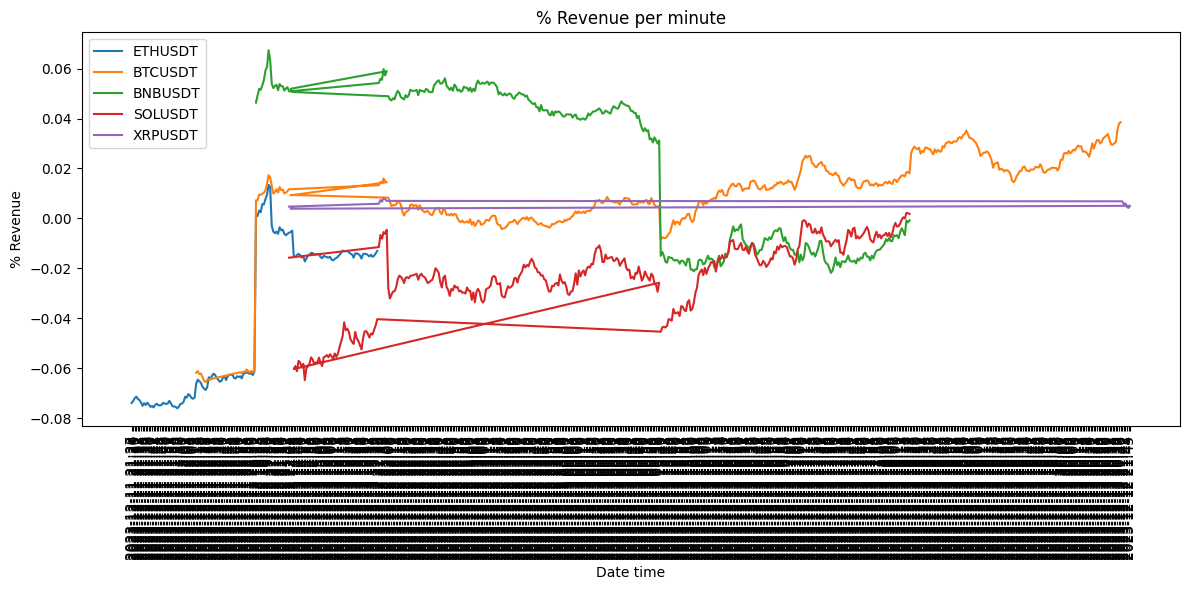

In [42]:
pdf = crypto_df.toPandas()
symbols = pdf["symbol"].unique()  # Get unique symbols in the DataFrame

plt.figure(figsize=(12, 6))

for symbol in symbols:
    symbol_data = pdf[pdf["symbol"] == symbol]
    plt.plot(symbol_data["date_time"], symbol_data["percentage_revenue"], label=f"{symbol}")

plt.xlabel("Date time")
plt.ylabel("% Revenue")
plt.title("% Revenue per minute")
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.legend()
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()


Revenue distribution

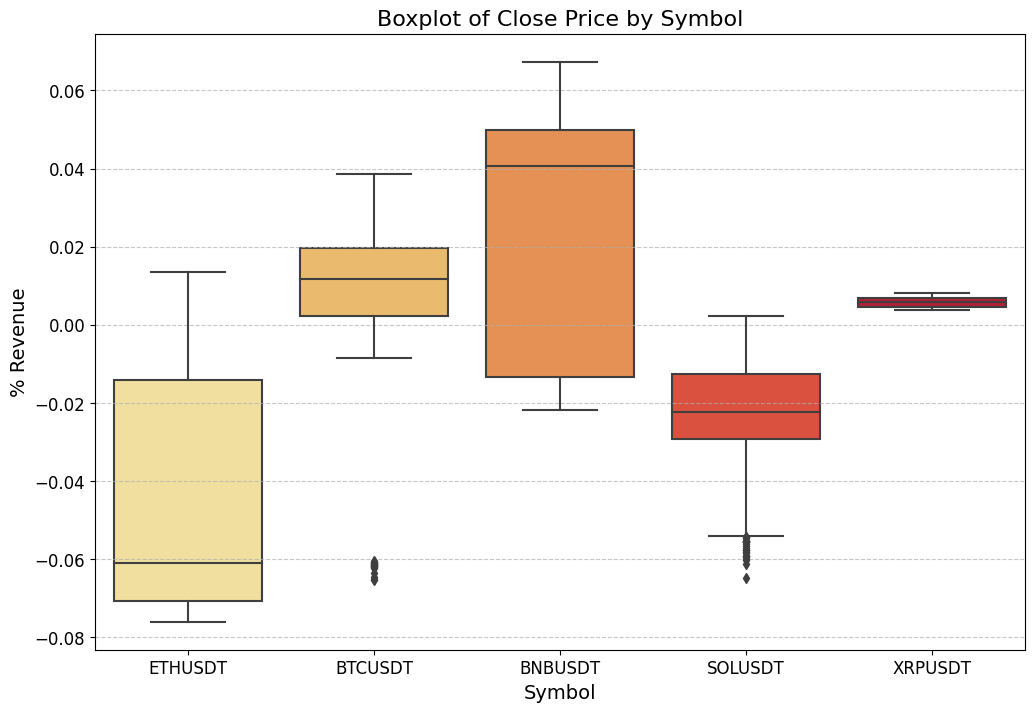

In [32]:
import seaborn as sns

# Select the relevant columns from the DataFrame
price_data = crypto_df.select("symbol", "percentage_revenue").toPandas()

# Monochrome Orange Color Palette
colors = sns.color_palette("YlOrRd", n_colors=len(price_data['symbol'].unique()))

# Create a boxplot for each symbol using Seaborn
plt.figure(figsize=(12, 8))
sns.boxplot(x="symbol", y="percentage_revenue", data=price_data, palette=colors)
plt.title("Boxplot of Close Price by Symbol", fontsize=16)
plt.xlabel("Symbol", fontsize=14)
plt.ylabel("% Revenue", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


Volatility

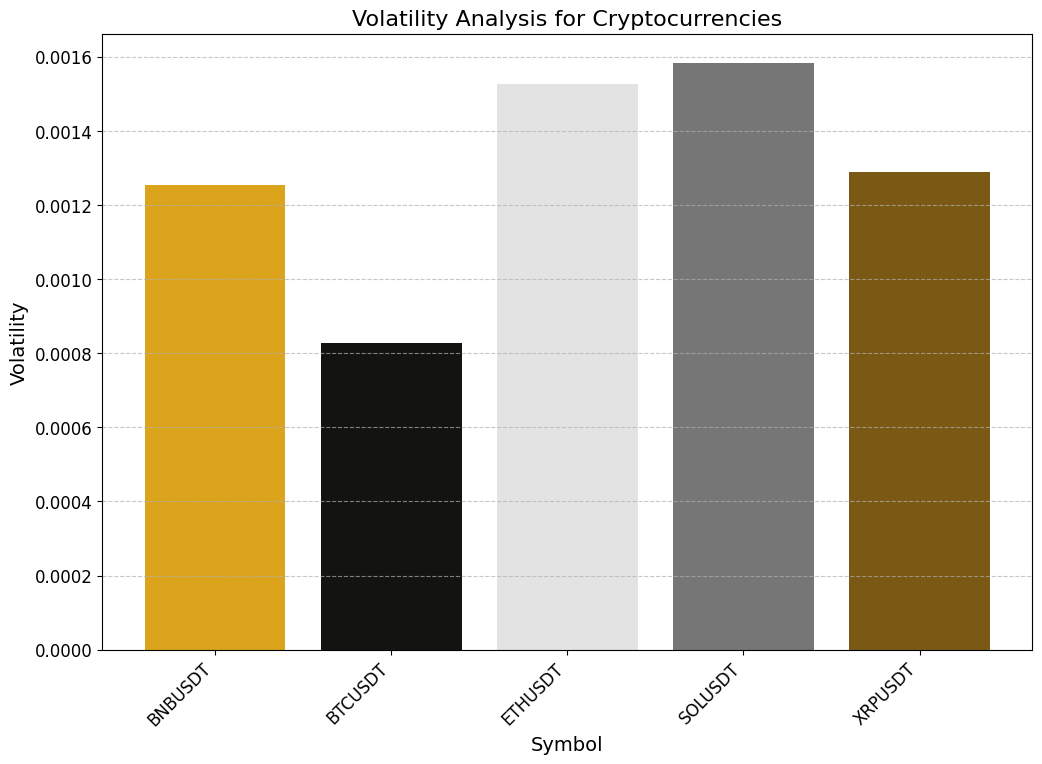

In [15]:

# Alias and calculate daily returns
volatility = crypto_df.alias("volatility")
window_spec = Window.partitionBy("symbol").orderBy("date_time")
volatility = volatility.withColumn("daily_return", (F.col("close_price") / F.lag("close_price").over(window_spec)) - 1)

# Calculate daily volatility (standard deviation of returns) for each symbol
volatility_df = volatility.groupBy("symbol").agg(
    F.stddev("daily_return").alias("volatility")
)

# Convert to Pandas DataFrame
volatility_pd = volatility_df.toPandas()

# Color Palette
colors = ['#dba41c', '#131312', '#e3e3e3', '#767676', '#795914', '#acacab', '#b5b9b6', '#dec98c', '#6c746c']

# Plot the volatility data
plt.figure(figsize=(12, 8))
plt.bar(volatility_pd['symbol'], volatility_pd['volatility'], color=colors)
plt.xlabel('Symbol', fontsize=14)
plt.ylabel('Volatility', fontsize=14)
plt.title('Volatility Analysis for Cryptocurrencies', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

Correlation

In [16]:
crypto_df.limit(5).toPandas()

,symbol,date_time,open_price,close_price,high_price,low_price,percentage_revenue
0,ETHUSDT,2023-12-11 21:27,2359.20,2184.89,2377.47,2156.62,-0.073885
1,ETHUSDT,2023-12-11 21:28,2359.20,2186.79,2377.47,2156.62,-0.073080
2,ETHUSDT,2023-12-11 21:29,2358.35,2188.71,2377.47,2156.62,-0.071932
3,ETHUSDT,2023-12-11 21:30,2358.10,2189.90,2377.47,2156.62,-0.071329
4,ETHUSDT,2023-12-11 21:31,2356.85,2186.48,2377.47,2156.62,-0.072287


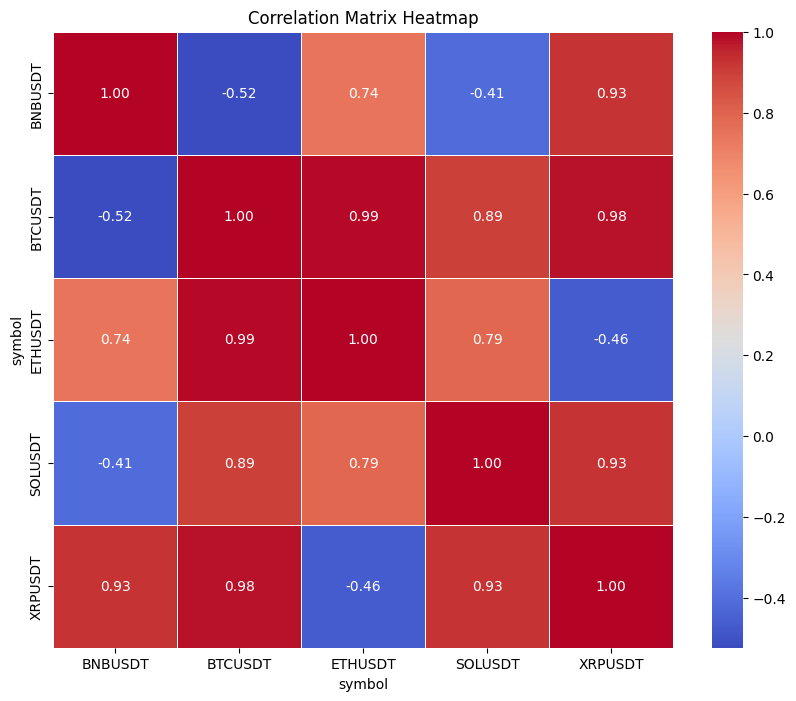

In [17]:
pivot_df = crypto_df.toPandas().pivot(index='date_time', columns='symbol', values='percentage_revenue')

corr_matrix = pivot_df.corr()


# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

Outliers

In [18]:
crypto_outliers = crypto_df.toPandas()


# Function to identify outliers based on IQR for each symbol
def identify_outliers(group):
    Q1 = group['percentage_revenue'].quantile(0.25)
    Q3 = group['percentage_revenue'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers_count = ((group['percentage_revenue'] < lower_bound) | (group['percentage_revenue'] > upper_bound)).sum()
    return pd.Series({'outliers_count': outliers_count})

# Identify outliers count for each symbol
outliers_count = crypto_outliers.groupby('symbol').apply(identify_outliers).reset_index()

# Display the outliers count table
outliers_count

,symbol,outliers_count
0,BNBUSDT,0
1,BTCUSDT,18
2,ETHUSDT,0
3,SOLUSDT,28
4,XRPUSDT,0


Candlestick

In [19]:
crypto_df.show()

+-------+----------------+----------+-----------+----------+---------+--------------------+
| symbol|       date_time|open_price|close_price|high_price|low_price|  percentage_revenue|
+-------+----------------+----------+-----------+----------+---------+--------------------+
|ETHUSDT|2023-12-11 21:27|    2359.2|    2184.89|   2377.47|  2156.62|-0.07388521532722955|
|ETHUSDT|2023-12-11 21:28|    2359.2|    2186.79|   2377.47|  2156.62|-0.07307985757884022|
|ETHUSDT|2023-12-11 21:29|   2358.35|    2188.71|   2377.47|  2156.62|-0.07193164712616867|
|ETHUSDT|2023-12-11 21:30|    2358.1|     2189.9|   2377.47|  2156.62|-0.07132861201815013|
|ETHUSDT|2023-12-11 21:31|   2356.85|    2186.48|   2377.47|  2156.62|-0.07228716295054836|
|ETHUSDT|2023-12-11 21:32|   2356.72|     2185.4|   2377.47|  2156.62| -0.0726942530296343|
|ETHUSDT|2023-12-11 21:33|    2358.8|     2185.0|   2377.47|  2156.62|-0.07368153298287272|
|ETHUSDT|2023-12-11 21:34|   2359.94|    2182.98|   2377.47|  2156.62|-0.0749849

Volume

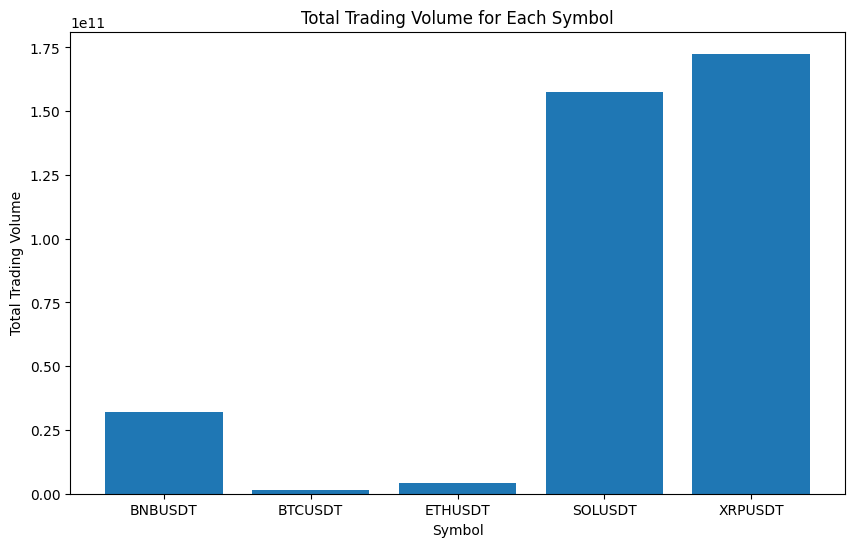

In [20]:
# Assuming these are the correct column names
crypto_trading_volume = df.toPandas()

# Calculate total trading volume for each symbol
total_volume_per_symbol = crypto_trading_volume.groupby('symbol')['total_volume'].sum().reset_index()

# Display the total trading volume for each symbol
plt.figure(figsize=(10, 6))
plt.bar(total_volume_per_symbol['symbol'], total_volume_per_symbol['total_volume'])
plt.title('Total Trading Volume for Each Symbol')
plt.xlabel('Symbol')
plt.ylabel('Total Trading Volume')
plt.show()

### Stocks

In [21]:
stocks_df.describe().show()

+-------+----------------+------------------+------------------+------------------+------------------+------------------+-------------------+------+
|summary|       date_time|        open_price|        high_price|         low_price|        last_price|       close_price|             volume|symbol|
+-------+----------------+------------------+------------------+------------------+------------------+------------------+-------------------+------+
|  count|           16145|             16145|             16145|             16145|             16145|             16145|              16145| 16145|
|   mean|            null| 264.7562892536562|266.38873273463713|262.51629699597805|264.73034004336125| 264.7408006506054|   9288684.00514091|  null|
| stddev|            null|134.64727092906142| 135.8510056126361|132.98201943347124|134.58913255878306|134.43323880453602|1.793059143837422E7|  null|
|    min|2023-12-11 14:00|            131.81|           132.135|            131.26|           131.915|131.

Timeframe

In [46]:
stock_agg = stocks_df.agg(
    F.from_unixtime(F.min(F.unix_timestamp(F.col("date_time"), "MM/dd/yyyy HH:mm"))).alias("min_event_time"),
    F.from_unixtime(F.max(F.unix_timestamp(F.col("date_time"), "MM/dd/yyyy HH:mm"))).alias("max_event_time")
)

# Show the result
stock_agg.show(truncate=False)

+--------------+--------------+
|min_event_time|max_event_time|
+--------------+--------------+
|null          |null          |
+--------------+--------------+



Different Stocks

In [45]:
stocks_stats = stocks_df.groupBy("symbol").agg(
    F.count("symbol").alias("count"),
    F.from_unixtime(F.min(F.unix_timestamp(F.col("date_time"), "MM/dd/yyyy HH:mm"))).alias("min_event_time"),
    F.from_unixtime(F.max(F.unix_timestamp(F.col("date_time"), "MM/dd/yyyy HH:mm"))).alias("max_event_time"),
    F.avg("close_price").alias("avg_close_price"),
    F.min("close_price").alias("min_close_price"),
    F.max("close_price").alias("max_close_price"),
    ((F.last("close_price") - F.first("close_price")) / F.first("close_price")).alias("total_return")  # Assuming "close_price" represents a financial value
)


stocks_stats.toPandas()

,symbol,count,min_event_time,max_event_time,avg_close_price,min_close_price,max_close_price,total_return
0,AAPL,3241,None,None,193.972011,192.656221,196.886662,-0.011055
1,GOOGL,3181,None,None,133.163653,131.825622,135.530744,-0.013228
2,AMZN,3181,None,None,146.565517,145.062648,148.030819,0.006047
3,MSFT,3301,None,None,372.698503,370.761094,375.157246,-0.002070
4,NVDA,3241,None,None,470.682101,464.300212,476.571981,0.005742


Time series % revenue

/tmp/ipykernel_2017/3768786451.py:22: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  stock_data_resampled = stock_data.resample('1H').mean()


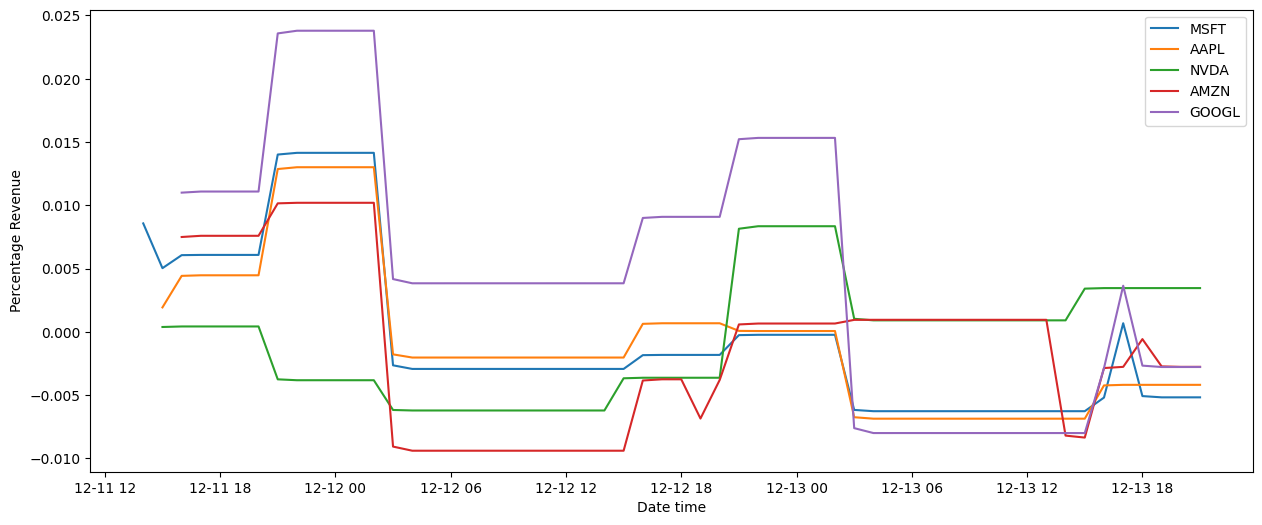

In [51]:
stock_time = stocks_df.alias("stock_time")
stock_time = stock_time.withColumn("date_time", col("date_time").cast("timestamp"))
stock_time = stocks_df.toPandas()

# Get unique symbols in the DataFrame
stocks = stock_time["symbol"].unique()

# Increase the figure width for better spacing
plt.figure(figsize=(15, 6))


stock_time['date_time'] = pd.to_datetime(stock_time['date_time'])

# Set 'date_time' as the index
stock_time = stock_time.set_index('date_time')

# Iterate over unique stocks and plot
for stock in stock_time['symbol'].unique():
    stock_data = stock_time[stock_time["symbol"] == stock]
    
    # Resample the data to intervals of 1 hour and calculate the mean
    stock_data_resampled = stock_data.resample('1H').mean()
    
    plt.plot(stock_data_resampled.index, stock_data_resampled["percentage_revenue"], label=f"{stock}")

plt.xlabel("Date time")
plt.ylabel("Percentage Revenue")
plt.legend()
plt.show()

Revenue distribution

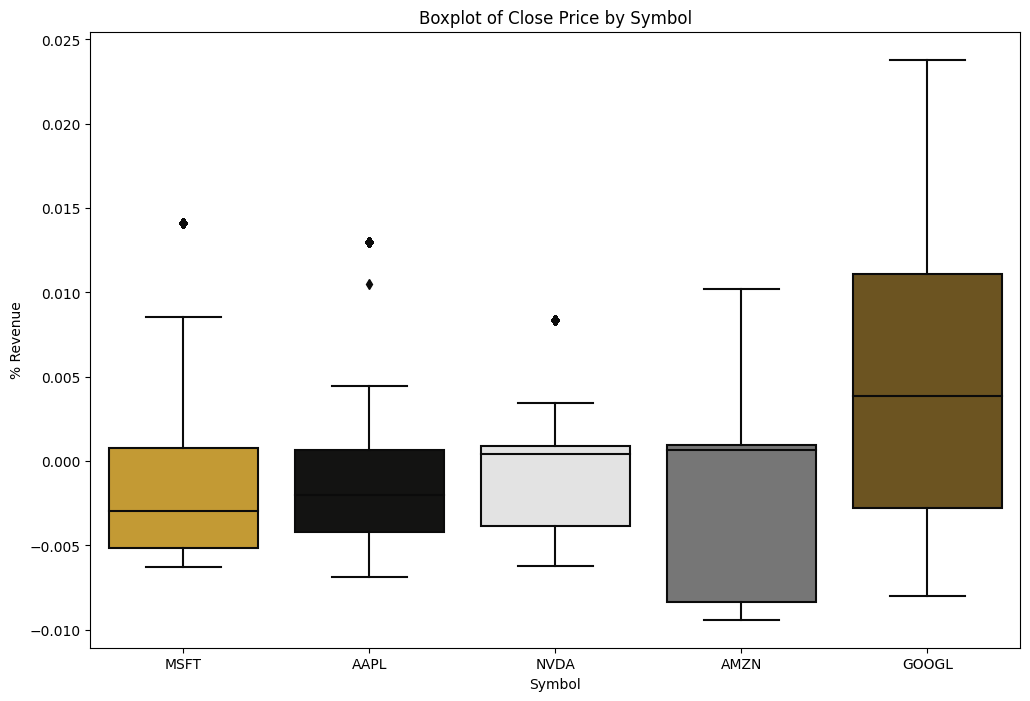

In [52]:
import seaborn as sns

# Select the relevant columns from the DataFrame
priceS_data = stocks_df.select("symbol", "percentage_revenue").toPandas()

# Color Palette
boxplot_colors = ['#dba41c', '#131312', '#e3e3e3', '#767676', '#795914', '#acacab', '#b5b9b6', '#dec98c', '#6c746c']

# Create a boxplot for each symbol using Seaborn
plt.figure(figsize=(12, 8))
sns.boxplot(x="symbol", y="percentage_revenue", data=priceS_data, palette=boxplot_colors)
plt.title("Boxplot of Close Price by Symbol")
plt.xlabel("Symbol")
plt.ylabel("% Revenue")
plt.show()


Volatility

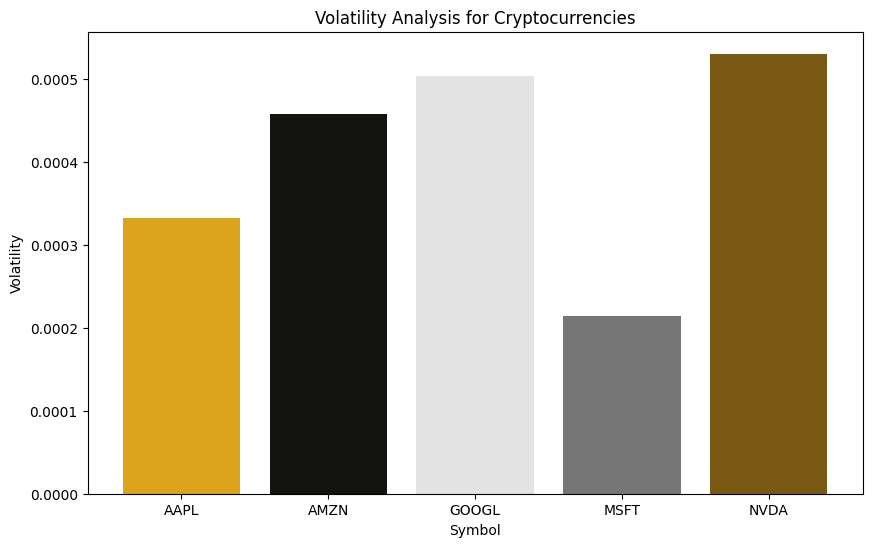

In [53]:
from pyspark.sql.window import Window

volatilityS = stocks_df.alias("volatility")

# Add a new column for daily returns
window_spec = Window.partitionBy("symbol").orderBy("date_time")
volatilityS = volatilityS.withColumn("daily_return", (F.col("close_price") / F.lag("close_price").over(window_spec)) - 1)

# Calculate daily volatility (standard deviation of returns) for each symbol
volatilityS_df = volatilityS.groupBy("symbol").agg(
    F.stddev("daily_return").alias("volatility")
)

volatilityS_pd = volatilityS_df.toPandas()

# Color Palette
barplot_colors = ['#dba41c', '#131312', '#e3e3e3', '#767676', '#795914', '#acacab', '#b5b9b6', '#dec98c', '#6c746c']

# Plot the volatility data
plt.figure(figsize=(10, 6))
plt.bar(volatilityS_pd['symbol'], volatilityS_pd['volatility'], color=barplot_colors)
plt.xlabel('Symbol')
plt.ylabel('Volatility')
plt.title('Volatility Analysis for Cryptocurrencies')
plt.show()


Correlation

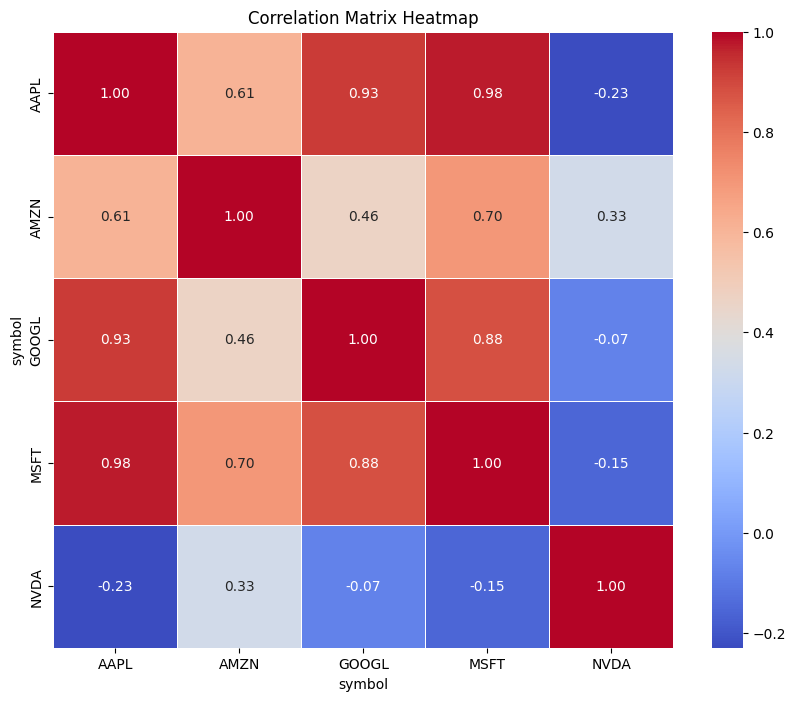

In [54]:
pivotS_df = stocks_df.toPandas().pivot(index='date_time', columns='symbol', values='percentage_revenue')

corr_matrixS = pivotS_df.corr()


# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrixS, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

Outliers

In [55]:
stocks_outliers = stocks_df.toPandas()

# Identify outliers count for each symbol
outliers_count_stock = stocks_outliers.groupby('symbol').apply(identify_outliers).reset_index()

# Display the outliers count table
outliers_count_stock

,symbol,outliers_count
0,AAPL,361
1,AMZN,0
2,GOOGL,0
3,MSFT,360
4,NVDA,360


Volume

## Commodities

In [ ]:
commodities_df.describe().toPandas()

Timeframe

In [56]:
commodities_agg = commodities_df.agg(
    F.from_unixtime(F.min(F.unix_timestamp(F.col("date_time"), "yyyy-MM-dd HH:mm"))).alias("min_event_time"),
    F.from_unixtime(F.max(F.unix_timestamp(F.col("date_time"), "yyyy-MM-dd HH:mm"))).alias("max_event_time")
)

# Show the result
commodities_agg.show(truncate=False)

+-------------------+-------------------+
|min_event_time     |max_event_time     |
+-------------------+-------------------+
|2023-12-11 00:00:00|2023-12-13 21:00:00|
+-------------------+-------------------+



Different Commodities

In [57]:
commodities_stats = commodities_df.groupBy("symbol").agg(
    F.count("symbol").alias("count"),
    F.from_unixtime(F.min(F.unix_timestamp(F.col("date_time"), "yyyy-MM-dd HH:mm"))).alias("min_event_time"),
    F.from_unixtime(F.max(F.unix_timestamp(F.col("date_time"), "yyyy-MM-dd HH:mm"))).alias("max_event_time"),
    F.avg("close_price").alias("avg_close_price"),
    F.min("close_price").alias("min_close_price"),
    F.max("close_price").alias("max_close_price"),
    ((F.last("close_price") - F.first("close_price")) / F.first("close_price")).alias("total_return")  # Assuming "close_price" represents a financial value
)


commodities_stats.toPandas()

,symbol,count,min_event_time,max_event_time,avg_close_price,min_close_price,max_close_price,total_return
0,GOLD,4141,2023-12-11 00:00:00,2023-12-13 21:00:00,16.521532,16.127079,16.904176,0.014567
1,SLV,4141,2023-12-11 00:00:00,2023-12-13 21:00:00,20.499913,20.203061,21.284514,NaN


Time series % revenue

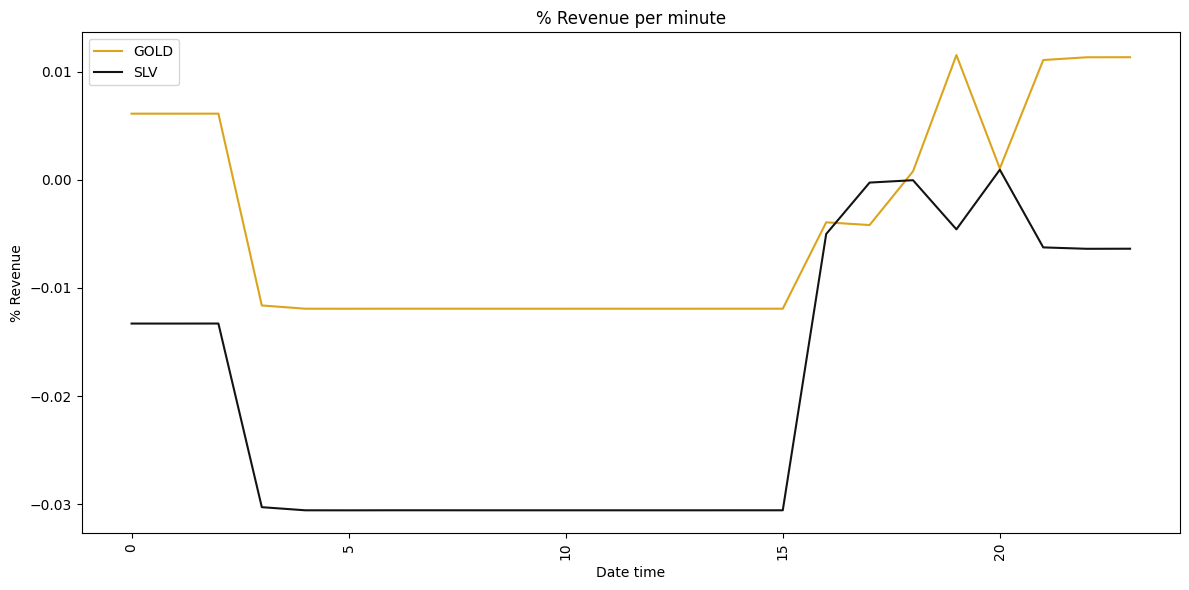

In [58]:
pdfC = commodities_df.toPandas()
symbols = pdfC["symbol"].unique()  # Get unique symbols in the DataFrame

# Color Palette
lineplot_colors = ['#dba41c', '#131312', '#e3e3e3', '#767676', '#795914', '#acacab', '#b5b9b6', '#dec98c', '#6c746c']

plt.figure(figsize=(12, 6))

pdfC['date_time'] = pd.to_datetime(pdfC['date_time'], format='%Y-%m-%d %H:%M:%S.%f', errors='coerce')
grouped_df = pdfC.groupby(['symbol', pdfC['date_time'].dt.hour])['percentage_revenue'].mean().reset_index()

for i, symbol in enumerate(symbols):
    symbol_data = grouped_df[grouped_df["symbol"] == symbol]
    plt.plot(symbol_data["date_time"], symbol_data["percentage_revenue"], label=f"{symbol}", color=lineplot_colors[i])

plt.xlabel("Date time")
plt.ylabel("% Revenue")
plt.title("% Revenue per minute")
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.legend()
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()


Revenue distribution

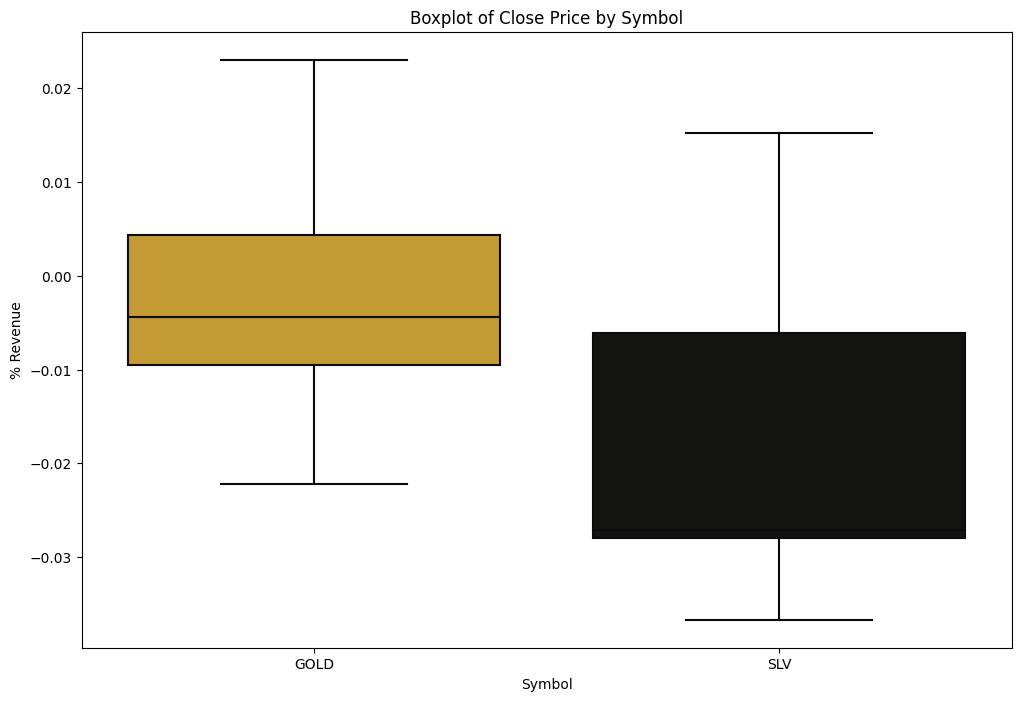

In [59]:
# Select the relevant columns from the DataFrame
priceC_data = commodities_df.select("symbol", "percentage_revenue").toPandas()

# Color Palette
boxplot_colors = ['#dba41c', '#131312', '#e3e3e3', '#767676', '#795914', '#acacab', '#b5b9b6', '#dec98c', '#6c746c']

# Create a boxplot for each symbol using Seaborn
plt.figure(figsize=(12, 8))
sns.boxplot(x="symbol", y="percentage_revenue", data=priceC_data, palette=boxplot_colors)
plt.title("Boxplot of Close Price by Symbol")
plt.xlabel("Symbol")
plt.ylabel("% Revenue")
plt.show()


Volatility

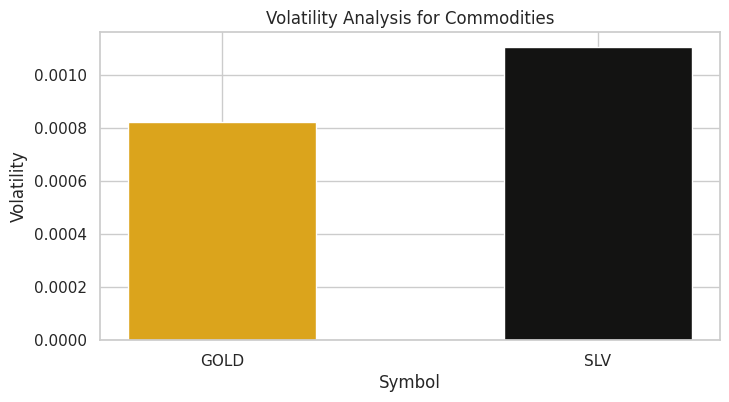

In [93]:
volatilityC = commodities_df.alias("volatility")

# Add a new column for daily returns
window_spec = Window.partitionBy("symbol").orderBy("date_time")
volatilityC = volatilityC.withColumn("daily_return", (F.col("close_price") / F.lag("close_price").over(window_spec)) - 1)

# Calculate daily volatility (standard deviation of returns) for each symbol
volatilityC_df = volatilityC.groupBy("symbol").agg(
    F.stddev("daily_return").alias("volatility")
)

volatilityC_pd = volatilityC_df.toPandas()

# Color Palette
barplot_colors = ['#dba41c', '#131312', '#e3e3e3', '#767676', '#795914', '#acacab', '#b5b9b6', '#dec98c', '#6c746c']

# Make the figure size smaller
plt.figure(figsize=(8, 4))

# Make the bars thinner by adjusting the width parameter
plt.bar(volatilityC_pd['symbol'], volatilityC_pd['volatility'], color=barplot_colors, width=0.5)  # Adjust the width as needed

plt.xlabel('Symbol')
plt.ylabel('Volatility')
plt.title('Volatility Analysis for Commodities')
plt.show()


Correlation

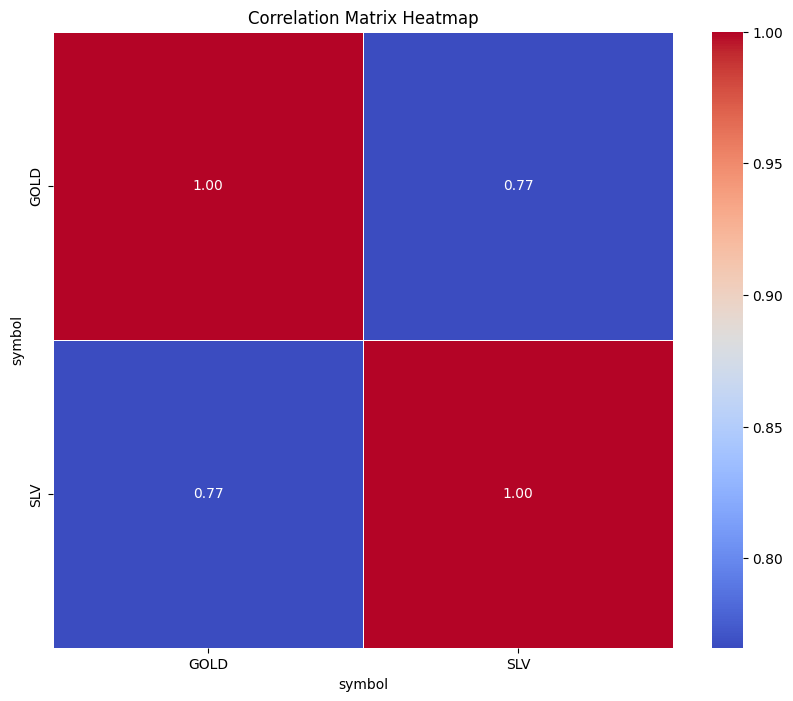

In [61]:
pivotC_df = commodities_df.toPandas().pivot(index='date_time', columns='symbol', values='percentage_revenue')

corr_matrixC = pivotC_df.corr()


# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrixC, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

Outliers

In [62]:
commodities_outliers = commodities_df.toPandas()

# Identify outliers count for each symbol
outliers_count_commodities = commodities_outliers.groupby('symbol').apply(identify_outliers).reset_index()

# Display the outliers count table
outliers_count_commodities

,symbol,outliers_count
0,GOLD,0
1,SLV,0


Volume

# Asset insights

In [63]:
crypto_pandas = crypto_df.toPandas()
stocks_pandas = stocks_df.toPandas()
commodities_pandas = commodities_df.toPandas()

# Define a common set of columns
common_columns = set(crypto_pandas.columns).intersection(stocks_pandas.columns).intersection(commodities_pandas.columns)
common_columns

{'close_price',
 'date_time',
 'high_price',
 'low_price',
 'open_price',
 'percentage_revenue',
 'symbol'}

In [81]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import lit
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, TimestampType
from pyspark.sql.functions import lit, date_format


# Define the schema for the empty DataFrame
empty_schema = StructType([
    StructField("symbol", StringType(), True),
    StructField("date_time", TimestampType(), True),
    StructField("open_price", DoubleType(), True),
    StructField("close_price", DoubleType(), True),
    StructField("percentage_revenue", DoubleType(), True),
    StructField("source_df", StringType(), True)  # Add a column to indicate the source DataFrame
])

# Create an empty DataFrame with the defined schema
empty_df = spark.createDataFrame([], schema=empty_schema)

# Assuming you already have the three DataFrames defined: crypto_df, stocks_df, and commodities_df

# Add a column indicating the source DataFrame
crypto_data = crypto_df.withColumn("source_df", lit("crypto"))
stocks_data = stocks_df.withColumn("source_df", lit("stocks"))
commodities_data = commodities_df.withColumn("source_df", lit("commodities"))

# Select and rename columns from crypto_df
crypto_data = crypto_data.selectExpr("symbol", "CAST(date_time AS TIMESTAMP) as date_time", "open_price", "close_price", "percentage_revenue", "source_df")

# Select and rename columns from stocks_df
stocks_data = stocks_data.selectExpr("symbol", "date_time", "open_price", "close_price", "percentage_revenue", "source_df")

# Select and rename columns from commodities_df
commodities_data = commodities_data.selectExpr("symbol", "CAST(date_time AS TIMESTAMP) as date_time", "open_price", "close_price", "percentage_revenue", "source_df")

# Union all the data into the empty DataFrame
assets_df = empty_df.union(crypto_data).union(stocks_data).union(commodities_data)\
    .withColumn("date_time", date_format("date_time", "yyyy-MM-dd HH:mm"))

# Show the result
assets_df.toPandas()

,symbol,date_time,open_price,close_price,percentage_revenue,source_df
0,ETHUSDT,2023-12-11 21:27,2359.200,2184.890000,-0.073885,crypto
1,ETHUSDT,2023-12-11 21:28,2359.200,2186.790000,-0.073080,crypto
2,ETHUSDT,2023-12-11 21:29,2358.350,2188.710000,-0.071932,crypto
3,ETHUSDT,2023-12-11 21:30,2358.100,2189.900000,-0.071329,crypto
4,ETHUSDT,2023-12-11 21:31,2356.850,2186.480000,-0.072287,crypto
...,...,...,...,...,...,...
25863,SLV,2023-12-11 00:04,21.035,20.464418,-0.027125,commodities
25864,SLV,2023-12-11 00:03,21.035,20.464607,-0.027116,commodities
25865,SLV,2023-12-11 00:02,21.035,20.464871,-0.027104,commodities
25866,SLV,2023-12-11 00:01,21.035,20.464447,-0.027124,commodities


In [82]:
assets_stats = assets_df.groupBy("symbol").agg(
    F.count("symbol").alias("count"),
    F.from_unixtime(F.min(F.unix_timestamp(F.col("date_time"), "MM/dd/yyyy HH:mm"))).alias("min_event_time"),
    F.from_unixtime(F.max(F.unix_timestamp(F.col("date_time"), "MM/dd/yyyy HH:mm"))).alias("max_event_time"),
    F.avg("close_price").alias("avg_close_price"),
    F.min("close_price").alias("min_close_price"),
    F.max("close_price").alias("max_close_price"),
    ((F.last("close_price") - F.first("close_price")) / F.first("close_price")).alias("total_return")  # Assuming "close_price" represents a financial value
)


assets_stats.toPandas()

,symbol,count,min_event_time,max_event_time,avg_close_price,min_close_price,max_close_price,total_return
0,ETHUSDT,157,None,None,2194.917070,2171.410000,2216.800000,0.001391
1,BTCUSDT,514,None,None,41684.741323,41044.330000,42792.950000,0.037457
2,BNBUSDT,362,None,None,253.468785,249.300000,256.800000,-0.004353
3,SOLUSDT,393,None,None,67.606260,66.550000,69.020000,0.005072
4,XRPUSDT,15,None,None,0.616087,0.614500,0.618400,0.006184
5,AAPL,3241,None,None,193.972011,192.656221,196.886662,-0.011055
6,MSFT,3301,None,None,372.698503,370.761094,375.157246,-0.002070
7,NVDA,3241,None,None,470.682101,464.300212,476.571981,0.005742
8,GOOGL,3181,None,None,133.163653,131.825622,135.530744,-0.013228
9,AMZN,3181,None,None,146.565517,145.062648,148.030819,0.006047


/opt/spark3/python/pyspark/sql/pandas/conversion.py:194: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


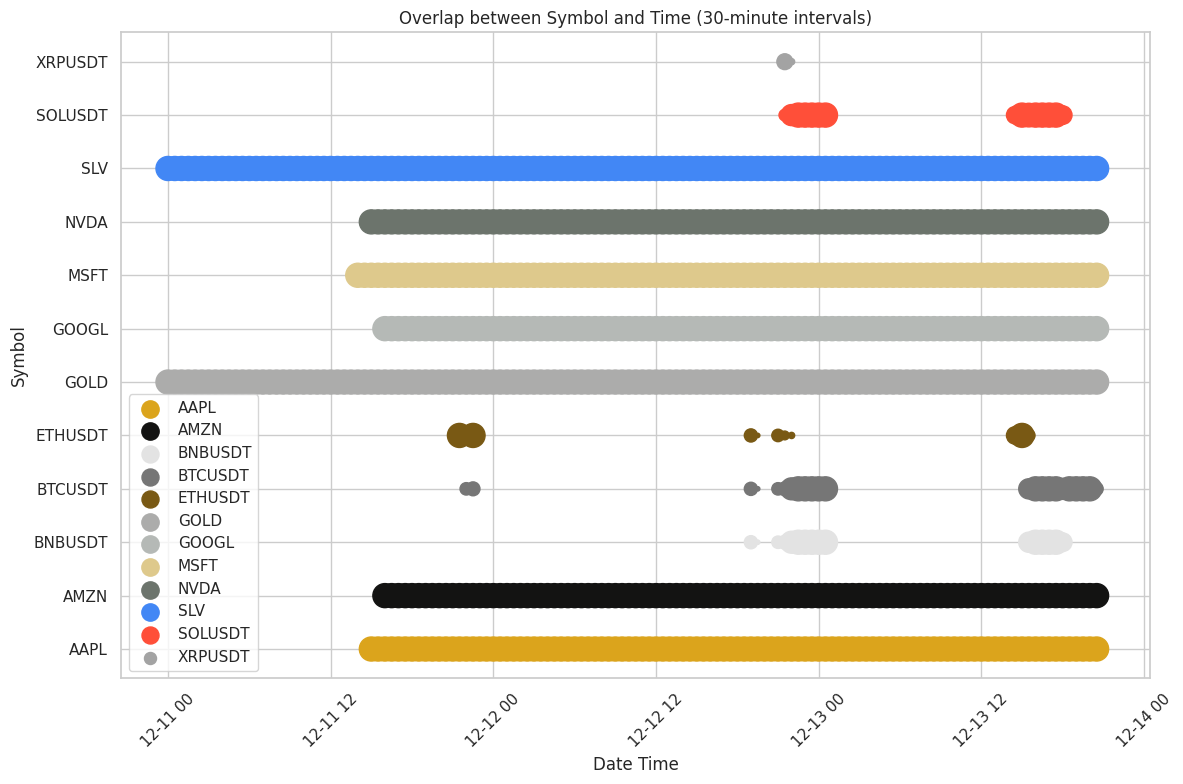

In [83]:
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql.functions import col
from pyspark.sql import Window
import seaborn as sns

# Assuming 'date_time' column is in string format, you need to cast it to a timestamp
assets_time = assets_df.alias("assets_time")
assets_time = assets_time.withColumn("date_time", col("date_time").cast("timestamp"))

# Create an alias to avoid changing the original DataFrame
pandas_df = assets_time[['symbol', 'date_time']].drop_duplicates().toPandas()

# Resample the data to 30-minute intervals
resampled_df = pandas_df.set_index('date_time').groupby('symbol').resample('30T').size().reset_index(name='count')

# Color Palette
scatterplot_colors = ['#dba41c', '#131312', '#e3e3e3', '#767676', '#795914', '#acacab', '#b5b9b6', '#dec98c', '#6c746c']

# Additional colors
additional_colors = ['#4287f5', '#ff4f39', '#a3a3a3', '#4d4d4d', '#94b8b8']

# Combine the color palettes
combined_colors = scatterplot_colors + additional_colors

# Assign unique colors for each symbol
symbol_colors = {symbol: combined_colors[i % len(combined_colors)] for i, symbol in enumerate(resampled_df['symbol'].unique())}

# Scatter plot to show the overlap
plt.figure(figsize=(12, 8))
for symbol in resampled_df['symbol'].unique():
    symbol_data = resampled_df[resampled_df['symbol'] == symbol]
    plt.scatter(symbol_data['date_time'], symbol_data['symbol'], s=symbol_data['count']*10, marker='o', color=symbol_colors[symbol], label=symbol)

plt.title('Overlap between Symbol and Time (30-minute intervals)')
plt.xlabel('Date Time')
plt.ylabel('Symbol')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


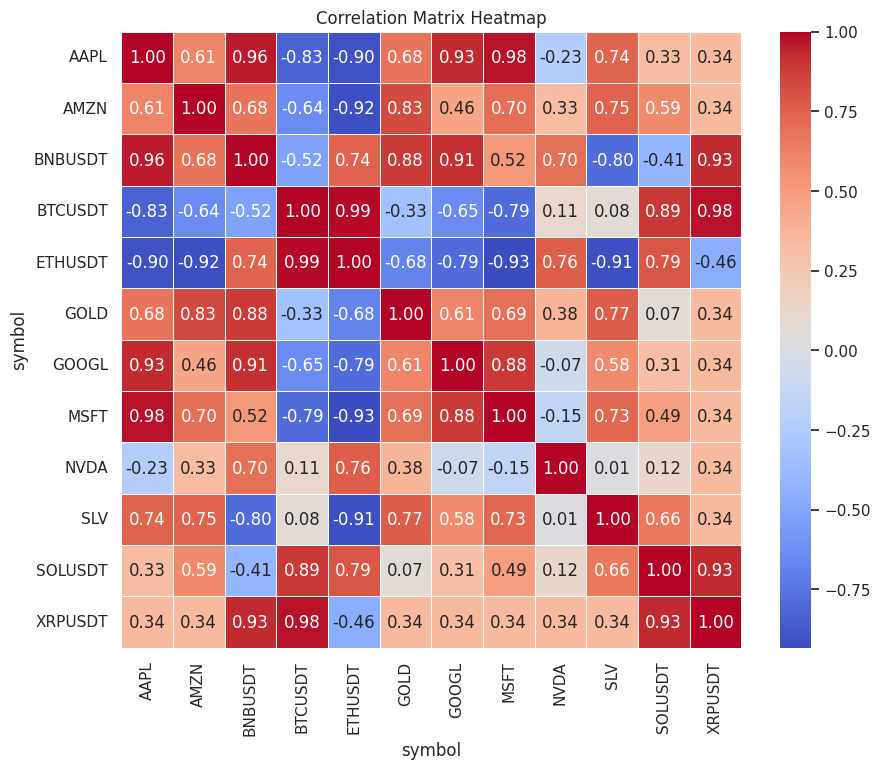

In [84]:
pivotA_df = assets_df.toPandas().pivot(index='date_time', columns='symbol', values='percentage_revenue')

corr_matrixA = pivotA_df.corr()


# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrixA, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

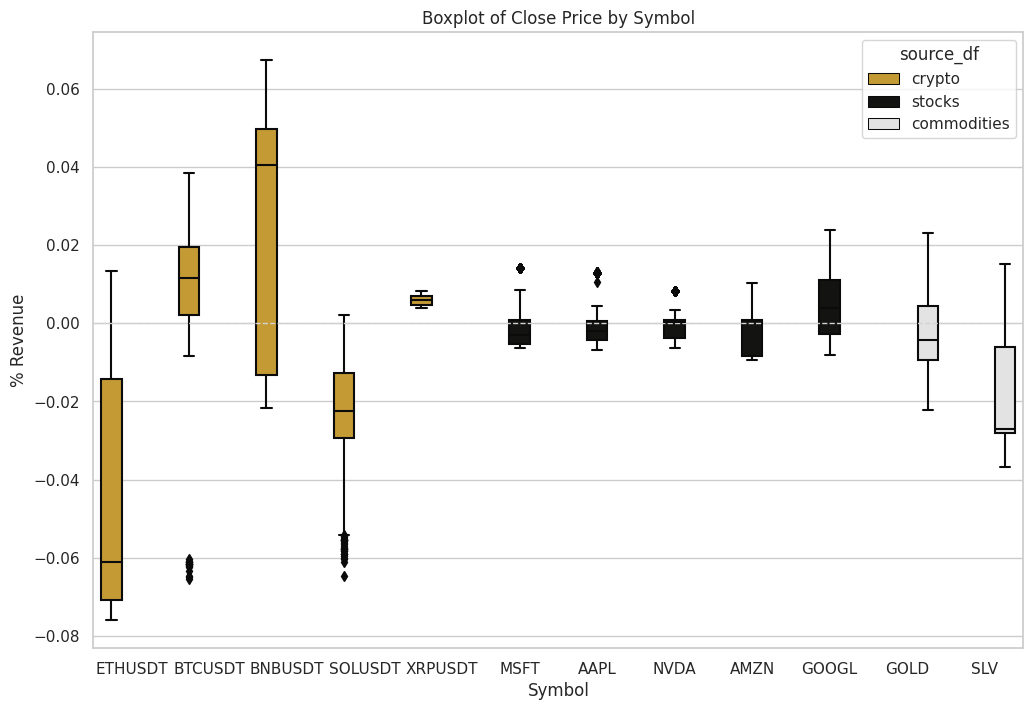

In [86]:
priceA_data = assets_df.select("symbol", "percentage_revenue", "source_df").toPandas()

# Custom Color Palette
boxplot_colors = ['#dba41c', '#131312', '#e3e3e3', '#767676', '#795914', '#acacab', '#b5b9b6', '#dec98c', '#6c746c']

# Additional colors
additional_colors = ['#4287f5', '#ff4f39', '#a3a3a3', '#4d4d4d', '#94b8b8']

# Combine the color palettes
combined_colors = boxplot_colors + additional_colors

# Create a custom color palette
custom_palette = sns.color_palette(combined_colors)

# Create a boxplot for each symbol using Seaborn, colored by source_df
plt.figure(figsize=(12, 8))
sns.boxplot(x="symbol", y="percentage_revenue", hue="source_df", data=priceA_data, palette=custom_palette)
plt.title("Boxplot of Close Price by Symbol")
plt.xlabel("Symbol")
plt.ylabel("% Revenue")
plt.axhline(y=0, color='lightgrey', linestyle='--', linewidth=1)
plt.show()

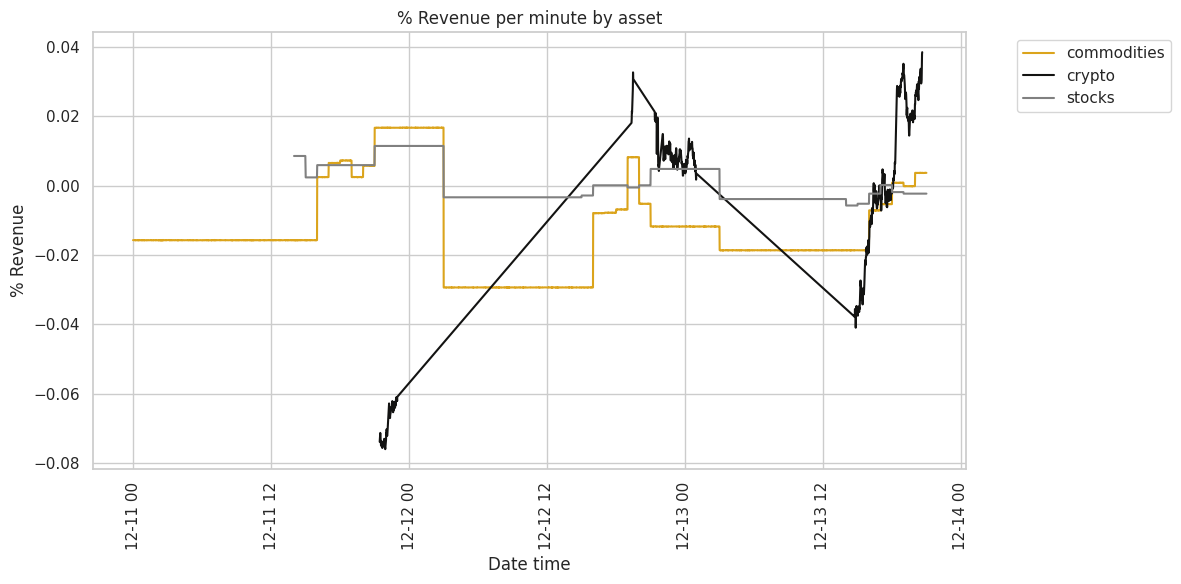

In [92]:
pdfA = assets_df.toPandas()

# Use the same custom color palette as in the first plot
boxplot_colors = ['#dba41c', '#131312', '#e3e3e3', '#767676', '#795914', '#acacab', '#b5b9b6', '#dec98c', '#6c746c']
additional_colors = ['#4287f5', '#ff4f39', '#a3a3a3', '#4d4d4d', '#94b8b8']
combined_colors = boxplot_colors + additional_colors
custom_palette = sns.color_palette(combined_colors)

plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")  # Use Seaborn for styling

pdfA['date_time'] = pd.to_datetime(pdfA['date_time'], format='%Y-%m-%d %H:%M:%S.%f', errors='coerce')
grouped_df = pdfA.groupby(['source_df', 'date_time'])['percentage_revenue'].mean().reset_index()

# Use the custom color palette for different source_df
for i, source_df in enumerate(grouped_df['source_df'].unique()):
    source_df_data = grouped_df[grouped_df["source_df"] == source_df]
    color = 'gray' if source_df == 'stocks' else custom_palette[i]
    
    plt.plot(
        source_df_data["date_time"],
        source_df_data["percentage_revenue"],
        label=f"{source_df}",
        color=color,
        linestyle='-'
    )

plt.xlabel("Date time")
plt.ylabel("% Revenue")
plt.title("% Revenue per minute by asset")
plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Place legend outside the plot area
plt.tight_layout()
plt.show()

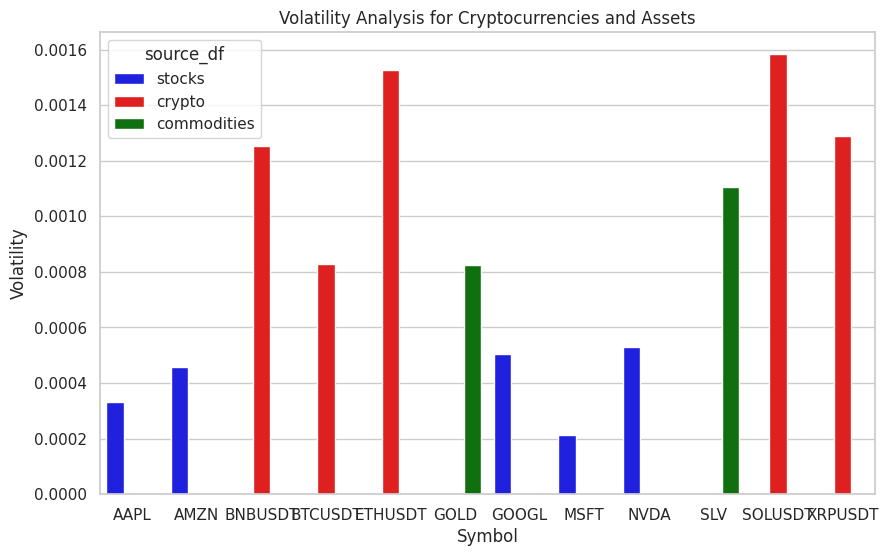

In [89]:
# Add a new column for daily returns
window_spec = Window.partitionBy("symbol").orderBy("date_time")
assets_df = assets_df.withColumn("daily_return", (F.col("close_price") / F.lag("close_price").over(window_spec)) - 1)

# Calculate daily volatility (standard deviation of returns) for each symbol
volatility_df = assets_df.groupBy("symbol", "source_df").agg(
    F.stddev("daily_return").alias("volatility")
)

# Convert PySpark DataFrame to Pandas DataFrame
volatility_pd = volatility_df.toPandas()

# Define a custom color palette (red for crypto, blue for stocks)
custom_palette = {'crypto': 'red', 'commodities': 'green', 'stocks': 'blue'}

# Plot the volatility data colored by source_df using the custom color palette
plt.figure(figsize=(10, 6))
sns.barplot(x='symbol', y='volatility', hue='source_df', data=volatility_pd, palette=custom_palette)
plt.xlabel('Symbol')
plt.ylabel('Volatility')
plt.title('Volatility Analysis for Cryptocurrencies and Assets')
plt.show()